In [17]:
#imports
import argparse
import torch
import torch.utils.data
import pickle
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import tables
import torch.nn.modules.upsampling as up

In [18]:
# Training settings
cuda = torch.cuda.is_available()

seed = 10


kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
imagesize ={'x':128,'y':128,'c':3}
n_classes = 10
X_dim = imagesize['x']*imagesize['y']*imagesize['c']
z_dim = 16*16*64
y_dim = 10
train_batch_size = 20
valid_batch_size = 20
N = 5000
epochs = 1000 #500

In [19]:
##################################
# Load data and create Data loaders
##################################
def load_data(data_path='../data/'):
    print('loading data!')
    filepath = "data/train_data"
    hdf5_file = tables.open_file(filepath, "r")
    # To access images array:
    trainset_unlabeled = hdf5_file.root.images
    #hdf5_file = tables.open_file(filepath, "r")
    #for i in range(len(trainset_unlabeled)):
    #    plt.imshow(trainset_unlabeled[i])
    #    plt.show()
    #print(len(trainset_unlabeled))
    #print(np.shape(trainset_unlabeled[0]))
    #trainset_unlabeled = pickle.load(open(data_path + "train_unlabeled.p", "rb"))
    # Set -1 as labels for unlabeled data
    trainset_unlabeled.train_labels = hdf5_file.root.labels
    filepath = "data/test_data"
    hdf5_file = tables.open_file(filepath, "r")
    # To access images array:
    validset_unlabeled = hdf5_file.root.images
    trainset_unlabeled.labels = hdf5_file.root.labels
    
    train_unlabeled_loader = torch.utils.data.DataLoader(trainset_unlabeled,
                                                         batch_size=train_batch_size,
                                                         shuffle=True, **kwargs)

    return train_unlabeled_loader,trainset_unlabeled

In [20]:

##################################
# Define Networks
##################################
# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.channels = [128,64,64]
        self.convkernel = [3]
        self.poolkernel = [2]
        self.conv1 = nn.Conv2d(imagesize['c'],self.channels[0],self.convkernel[0],padding=(1,1))
        self.conv2 = nn.Conv2d(self.channels[0],self.channels[1],self.convkernel[0],padding=(1,1))
        self.conv3 = nn.Conv2d(self.channels[1],self.channels[2],self.convkernel[0],padding=(1,1))
        #self.lin1 = nn.Linear(X_dim, N)
        #self.lin2 = nn.Linear(N, N)
        # Gaussian code (z)
        #self.lin3gauss = nn.Linear(self.channels[2]*18*18, z_dim)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size = self.poolkernel[0])
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size = self.poolkernel[0])
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size = self.poolkernel[0])
        #x = x.view(train_batch_size,self.channels[2]*18*18)
        #xgauss = F.dropout(self.lin3gauss(x), p=0.2, training=self.training)
        xgauss = x
        return xgauss


In [21]:

# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.channels = [128,64,64]
        self.convkernel = [3]
        self.poolkernel = [2]
        self.conv1 = nn.Conv2d(self.channels[2],self.channels[2],self.convkernel[0],padding=(1,1))
        self.ups1 = nn.UpsamplingBilinear2d(scale_factor=self.poolkernel[0])
        self.conv2 = nn.Conv2d(self.channels[2],self.channels[1],self.convkernel[0],padding=(1,1))
        self.ups2 = nn.UpsamplingBilinear2d(scale_factor=self.poolkernel[0])
        self.conv3 = nn.Conv2d(self.channels[1],self.channels[0],self.convkernel[0],padding=(1,1))
        self.ups3 = nn.UpsamplingBilinear2d(scale_factor=self.poolkernel[0])
        self.conv4 = nn.Conv2d(self.channels[0],imagesize['c'],self.convkernel[0],padding=(1,1))
        
    def forward(self, x):
        x = self.ups1(F.relu(self.conv1(x)))
        x = self.ups2(F.relu(self.conv2(x)))
        x = self.ups3(F.relu(self.conv3(x)))
        x = self.conv4(x)
        return F.sigmoid(x)

In [22]:

class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)

    def forward(self, x):
        x = x.view(train_batch_size,z_dim)
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)

        return F.sigmoid(self.lin3(x))

In [23]:

####################
# Utility functions
####################
def save_model(model, filename):
    print('Best model so far, saving it...')
    torch.save(model.state_dict(), filename)


def report_loss(epoch, D_loss_gauss, G_loss, recon_loss,valid_recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; D_loss_gauss: {:.4}; G_loss: {:.4}; recon_loss: {:.4}; valid_recon_loss: {:.4}'.format(epoch,
                                                                                   D_loss_gauss.data[0],
                                                                                   G_loss.data[0],
                                                                                   recon_loss.data[0],valid_recon_loss.data[0]))


def create_latent(Q, loader):
    '''
    Creates the latent representation for the samples in loader
    return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    Q.eval()
    labels = []

    for batch_idx, (X, target) in enumerate(loader):

        X = X * 0.3081 + 0.1307
        # X.resize_(loader.batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        labels.extend(target.data.tolist())
        if cuda:
            X, target = X.cuda(), target.cuda()
        # Reconstruction phase
        z_sample = Q(X)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z_sample.data.tolist())))
        else:
            z_values = np.array(z_sample.data.tolist())
    labels = np.array(labels)

    return z_values, labels


In [24]:

       
####################
# Train procedure
####################
def train(P, Q, D_gauss, P_decoder, Q_encoder, Q_generator, D_gauss_solver, data_loader,valid_data,update_disc = True):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()
    D_gauss.train()

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    last_g_loss = 100
    last_g_grad = 1
    v_size = len(valid_data)
    v_data = np.zeros((v_size,imagesize['c'],imagesize['x'],imagesize['y']))
    for i in range(v_size):
        v_data[i] = np.array(valid_data[i])
    v_data = 1 - v_data/255
    V = Variable(torch.FloatTensor(v_data))#.resize_(valid_batch_size, X_dim)
    if cuda:
            V= V.cuda()
    for X in data_loader:
        # Load batch and normalize samples to be between 0 and 1
        X = 1-X/255
        #X.resize_(train_batch_size, X_dim)
        X= Variable(X)
        X = X.type(torch.FloatTensor)
        if cuda:
            X= X.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        #######################
        # Reconstruction phase
        #######################
        z_sample = Q(X)
        X_sample = P(z_sample)
        recon_loss = F.binary_cross_entropy(X_sample + TINY, X + TINY) #.resize(train_batch_size, X_dim)
        recon_loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()
        
        # recon loss for valid set
        z_sample = Q(V)
        X_sample = P(z_sample)
        recon_loss_valid = F.binary_cross_entropy(X_sample + TINY, X + TINY) #.resize(train_batch_size, X_dim)
        P.zero_grad()
        Q.zero_grad()
        
        D_gauss.zero_grad()

        #######################
        # Regularization phase
        #######################
        # Discriminator
        Q.eval()
        z_real_gauss = Variable(torch.randn(train_batch_size, z_dim) * 5.)
        if cuda:
            z_real_gauss = z_real_gauss.cuda()

        z_fake_gauss = Q(X)
        #print('network',D_gauss)
        #print('fake', np.shape(z_fake_gauss))
        #print('real', np.shape(z_real_gauss))
        D_real_gauss = D_gauss(z_real_gauss)
        D_fake_gauss = D_gauss(z_fake_gauss)
        D_loss = -torch.mean(torch.log(D_real_gauss + TINY) + torch.log(1 - D_fake_gauss + TINY))
        if update_disc:#last_g_loss < D_loss.data[0]: #update_disc:
            #print(last_g_grad,D_loss.data[0])
            #print('updating descriminator')
            D_loss.backward()
            D_gauss_solver.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        # Generator
        Q.train()
        z_fake_gauss = Q(X)

        D_fake_gauss = D_gauss(z_fake_gauss)
        G_loss = -torch.mean(torch.log(D_fake_gauss + TINY))
        last_g_grad = last_g_loss - G_loss.data[0]
        last_g_loss = G_loss.data[0]
        G_loss.backward()
        Q_generator.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()
    return D_loss, G_loss, recon_loss, recon_loss_valid



In [25]:
def generate_model( train_unlabeled_loader,valid_data):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
        D_gauss = D_net_gauss().cuda()
    else:
        Q = Q_net()
        P = P_net()
        D_gauss = D_net_gauss()

    # Set learning rates
    gen_lr = 0.001
    reg_lr = 0.00005

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)

    Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
    D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)
    losses = []
    update_disc = True
    for epoch in range(epochs):
        D_loss_gauss, G_loss, recon_loss,recon_loss_valid = train(P, Q, D_gauss, P_decoder, Q_encoder,
                                                 Q_generator,
                                                 D_gauss_solver,
                                                 train_unlabeled_loader,valid_data,update_disc)
        if epoch % 1 == 0:#chaged here!
            report_loss(epoch, D_loss_gauss, G_loss, recon_loss,recon_loss_valid)
            losses.append((epoch, D_loss_gauss.data[0], G_loss.data[0], recon_loss.data[0],recon_loss_valid.data[0]))
            update_disc = D_loss_gauss.data[0] > G_loss.data[0]
    return Q, P

In [26]:
if __name__ == '__main__':
    train_unlabeled_loader,valid_data = load_data()
    Q, P = generate_model( train_unlabeled_loader,valid_data)

loading data!


/home/minato/.virtualenvs/dlcv/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


Epoch-0; D_loss_gauss: 1.54; G_loss: 0.6699; recon_loss: 0.692; valid_recon_loss: 0.6877
Epoch-1; D_loss_gauss: 0.7604; G_loss: 0.6629; recon_loss: 0.687; valid_recon_loss: 0.6797
Epoch-2; D_loss_gauss: 0.7601; G_loss: 0.7346; recon_loss: 0.6713; valid_recon_loss: 0.661
Epoch-3; D_loss_gauss: 0.6497; G_loss: 0.9338; recon_loss: 0.6254; valid_recon_loss: 0.614
Epoch-4; D_loss_gauss: 0.4373; G_loss: 1.058; recon_loss: 0.536; valid_recon_loss: 0.5898
Epoch-5; D_loss_gauss: 0.4675; G_loss: 1.0; recon_loss: 0.5452; valid_recon_loss: 0.5653
Epoch-6; D_loss_gauss: 0.5437; G_loss: 0.8789; recon_loss: 0.4678; valid_recon_loss: 0.6361
Epoch-7; D_loss_gauss: 0.5247; G_loss: 0.8993; recon_loss: 0.5143; valid_recon_loss: 0.5942
Epoch-8; D_loss_gauss: 0.4959; G_loss: 0.951; recon_loss: 0.43; valid_recon_loss: 0.6108
Epoch-9; D_loss_gauss: 0.5016; G_loss: 0.933; recon_loss: 0.3954; valid_recon_loss: 0.5938
Epoch-10; D_loss_gauss: 0.5637; G_loss: 0.8481; recon_loss: 0.3703; valid_recon_loss: 0.6246
Ep

Epoch-90; D_loss_gauss: 0.2981; G_loss: 1.364; recon_loss: 0.1159; valid_recon_loss: 2.433
Epoch-91; D_loss_gauss: 0.3115; G_loss: 1.348; recon_loss: 0.115; valid_recon_loss: 2.695
Epoch-92; D_loss_gauss: 0.3184; G_loss: 1.315; recon_loss: 0.114; valid_recon_loss: 2.648
Epoch-93; D_loss_gauss: 0.3153; G_loss: 1.318; recon_loss: 0.1138; valid_recon_loss: 2.405
Epoch-94; D_loss_gauss: 0.3297; G_loss: 1.299; recon_loss: 0.1143; valid_recon_loss: 2.708
Epoch-95; D_loss_gauss: 0.3227; G_loss: 1.317; recon_loss: 0.1145; valid_recon_loss: 2.461
Epoch-96; D_loss_gauss: 0.3274; G_loss: 1.291; recon_loss: 0.1141; valid_recon_loss: 2.719
Epoch-97; D_loss_gauss: 0.3309; G_loss: 1.274; recon_loss: 0.1129; valid_recon_loss: 2.573
Epoch-98; D_loss_gauss: 0.3388; G_loss: 1.272; recon_loss: 0.1123; valid_recon_loss: 2.446
Epoch-99; D_loss_gauss: 0.3486; G_loss: 1.262; recon_loss: 0.1125; valid_recon_loss: 2.731
Epoch-100; D_loss_gauss: 0.3341; G_loss: 1.261; recon_loss: 0.1129; valid_recon_loss: 2.447


Epoch-180; D_loss_gauss: 0.5816; G_loss: 0.8126; recon_loss: 0.1008; valid_recon_loss: 3.755
Epoch-181; D_loss_gauss: 0.5947; G_loss: 0.8128; recon_loss: 0.1006; valid_recon_loss: 3.771
Epoch-182; D_loss_gauss: 0.6032; G_loss: 0.8008; recon_loss: 0.09957; valid_recon_loss: 4.502
Epoch-183; D_loss_gauss: 0.6216; G_loss: 0.7981; recon_loss: 0.1002; valid_recon_loss: 3.49
Epoch-184; D_loss_gauss: 0.6041; G_loss: 0.7954; recon_loss: 0.1006; valid_recon_loss: 3.964
Epoch-185; D_loss_gauss: 0.5973; G_loss: 0.8085; recon_loss: 0.1; valid_recon_loss: 3.683
Epoch-186; D_loss_gauss: 0.6234; G_loss: 0.8006; recon_loss: 0.09938; valid_recon_loss: 3.972
Epoch-187; D_loss_gauss: 0.6289; G_loss: 0.7514; recon_loss: 0.09936; valid_recon_loss: 4.149
Epoch-188; D_loss_gauss: 0.6249; G_loss: 0.7904; recon_loss: 0.09996; valid_recon_loss: 4.046
Epoch-189; D_loss_gauss: 0.6203; G_loss: 0.7927; recon_loss: 0.09944; valid_recon_loss: 4.579
Epoch-190; D_loss_gauss: 0.656; G_loss: 0.767; recon_loss: 0.09915; v

Epoch-269; D_loss_gauss: 0.3553; G_loss: 1.252; recon_loss: 0.09402; valid_recon_loss: 4.481
Epoch-270; D_loss_gauss: 0.3574; G_loss: 1.176; recon_loss: 0.09466; valid_recon_loss: 6.088
Epoch-271; D_loss_gauss: 0.3551; G_loss: 1.214; recon_loss: 0.09492; valid_recon_loss: 4.3
Epoch-272; D_loss_gauss: 0.3708; G_loss: 1.191; recon_loss: 0.09482; valid_recon_loss: 5.548
Epoch-273; D_loss_gauss: 0.3651; G_loss: 1.191; recon_loss: 0.09408; valid_recon_loss: 5.074
Epoch-274; D_loss_gauss: 0.3691; G_loss: 1.203; recon_loss: 0.09286; valid_recon_loss: 5.086
Epoch-275; D_loss_gauss: 0.372; G_loss: 1.193; recon_loss: 0.09254; valid_recon_loss: 5.544
Epoch-276; D_loss_gauss: 0.3648; G_loss: 1.17; recon_loss: 0.09269; valid_recon_loss: 4.88
Epoch-277; D_loss_gauss: 0.3841; G_loss: 1.181; recon_loss: 0.09327; valid_recon_loss: 5.658
Epoch-278; D_loss_gauss: 0.3809; G_loss: 1.176; recon_loss: 0.09359; valid_recon_loss: 4.594
Epoch-279; D_loss_gauss: 0.3701; G_loss: 1.184; recon_loss: 0.09373; valid_

Epoch-358; D_loss_gauss: 0.5451; G_loss: 0.9095; recon_loss: 0.08942; valid_recon_loss: 6.275
Epoch-359; D_loss_gauss: 0.5593; G_loss: 0.9006; recon_loss: 0.08865; valid_recon_loss: 5.734
Epoch-360; D_loss_gauss: 0.5565; G_loss: 0.8745; recon_loss: 0.08741; valid_recon_loss: 5.613
Epoch-361; D_loss_gauss: 0.5833; G_loss: 0.8879; recon_loss: 0.08783; valid_recon_loss: 6.256
Epoch-362; D_loss_gauss: 0.5451; G_loss: 0.8808; recon_loss: 0.08817; valid_recon_loss: 6.093
Epoch-363; D_loss_gauss: 0.5568; G_loss: 0.8805; recon_loss: 0.08834; valid_recon_loss: 5.891
Epoch-364; D_loss_gauss: 0.5381; G_loss: 0.8769; recon_loss: 0.08865; valid_recon_loss: 6.02
Epoch-365; D_loss_gauss: 0.5925; G_loss: 0.883; recon_loss: 0.08732; valid_recon_loss: 6.361
Epoch-366; D_loss_gauss: 0.576; G_loss: 0.8507; recon_loss: 0.08723; valid_recon_loss: 5.911
Epoch-367; D_loss_gauss: 0.5642; G_loss: 0.864; recon_loss: 0.08648; valid_recon_loss: 5.675
Epoch-368; D_loss_gauss: 0.5512; G_loss: 0.8698; recon_loss: 0.0

Epoch-446; D_loss_gauss: 0.1283; G_loss: 2.17; recon_loss: 0.08237; valid_recon_loss: 6.646
Epoch-447; D_loss_gauss: 0.1205; G_loss: 2.232; recon_loss: 0.08308; valid_recon_loss: 6.145
Epoch-448; D_loss_gauss: 0.1196; G_loss: 2.168; recon_loss: 0.08329; valid_recon_loss: 6.854
Epoch-449; D_loss_gauss: 0.1213; G_loss: 2.229; recon_loss: 0.08255; valid_recon_loss: 6.503
Epoch-450; D_loss_gauss: 0.1213; G_loss: 2.219; recon_loss: 0.08245; valid_recon_loss: 6.221
Epoch-451; D_loss_gauss: 0.1281; G_loss: 2.132; recon_loss: 0.08219; valid_recon_loss: 6.17
Epoch-452; D_loss_gauss: 0.1227; G_loss: 2.112; recon_loss: 0.08222; valid_recon_loss: 6.029
Epoch-453; D_loss_gauss: 0.1293; G_loss: 2.132; recon_loss: 0.08269; valid_recon_loss: 6.801
Epoch-454; D_loss_gauss: 0.1269; G_loss: 2.117; recon_loss: 0.08223; valid_recon_loss: 5.981
Epoch-455; D_loss_gauss: 0.1362; G_loss: 2.139; recon_loss: 0.08166; valid_recon_loss: 6.325
Epoch-456; D_loss_gauss: 0.1268; G_loss: 2.124; recon_loss: 0.08182; val

Epoch-535; D_loss_gauss: 0.1953; G_loss: 1.699; recon_loss: 0.08364; valid_recon_loss: 6.589
Epoch-536; D_loss_gauss: 0.1928; G_loss: 1.766; recon_loss: 0.08143; valid_recon_loss: 6.848
Epoch-537; D_loss_gauss: 0.2147; G_loss: 1.661; recon_loss: 0.08286; valid_recon_loss: 7.23
Epoch-538; D_loss_gauss: 0.2163; G_loss: 1.658; recon_loss: 0.08107; valid_recon_loss: 7.001
Epoch-539; D_loss_gauss: 0.2065; G_loss: 1.698; recon_loss: 0.08366; valid_recon_loss: 6.794
Epoch-540; D_loss_gauss: 0.1969; G_loss: 1.721; recon_loss: 0.08035; valid_recon_loss: 6.83
Epoch-541; D_loss_gauss: 0.2037; G_loss: 1.78; recon_loss: 0.08066; valid_recon_loss: 6.505
Epoch-542; D_loss_gauss: 0.2175; G_loss: 1.708; recon_loss: 0.08024; valid_recon_loss: 7.017
Epoch-543; D_loss_gauss: 0.1972; G_loss: 1.739; recon_loss: 0.0797; valid_recon_loss: 7.549
Epoch-544; D_loss_gauss: 0.201; G_loss: 1.698; recon_loss: 0.0803; valid_recon_loss: 6.502
Epoch-545; D_loss_gauss: 0.2028; G_loss: 1.721; recon_loss: 0.07889; valid_r

Epoch-624; D_loss_gauss: 0.222; G_loss: 1.671; recon_loss: 0.07422; valid_recon_loss: 7.857
Epoch-625; D_loss_gauss: 0.2336; G_loss: 1.561; recon_loss: 0.07502; valid_recon_loss: 8.204
Epoch-626; D_loss_gauss: 0.2339; G_loss: 1.646; recon_loss: 0.07495; valid_recon_loss: 7.499
Epoch-627; D_loss_gauss: 0.2257; G_loss: 1.653; recon_loss: 0.07427; valid_recon_loss: 7.51
Epoch-628; D_loss_gauss: 0.242; G_loss: 1.637; recon_loss: 0.07315; valid_recon_loss: 7.881
Epoch-629; D_loss_gauss: 0.2107; G_loss: 1.641; recon_loss: 0.07314; valid_recon_loss: 7.104
Epoch-630; D_loss_gauss: 0.2288; G_loss: 1.596; recon_loss: 0.07399; valid_recon_loss: 7.954
Epoch-631; D_loss_gauss: 0.2166; G_loss: 1.675; recon_loss: 0.07457; valid_recon_loss: 7.039
Epoch-632; D_loss_gauss: 0.2134; G_loss: 1.59; recon_loss: 0.07447; valid_recon_loss: 8.379
Epoch-633; D_loss_gauss: 0.2361; G_loss: 1.633; recon_loss: 0.07342; valid_recon_loss: 7.721
Epoch-634; D_loss_gauss: 0.2385; G_loss: 1.606; recon_loss: 0.07297; valid

Epoch-713; D_loss_gauss: 0.2774; G_loss: 1.492; recon_loss: 0.06995; valid_recon_loss: 8.079
Epoch-714; D_loss_gauss: 0.2928; G_loss: 1.425; recon_loss: 0.07036; valid_recon_loss: 8.363
Epoch-715; D_loss_gauss: 0.2883; G_loss: 1.437; recon_loss: 0.06991; valid_recon_loss: 8.561
Epoch-716; D_loss_gauss: 0.2832; G_loss: 1.484; recon_loss: 0.06995; valid_recon_loss: 8.042
Epoch-717; D_loss_gauss: 0.2657; G_loss: 1.502; recon_loss: 0.06967; valid_recon_loss: 7.684
Epoch-718; D_loss_gauss: 0.3093; G_loss: 1.425; recon_loss: 0.06959; valid_recon_loss: 7.786
Epoch-719; D_loss_gauss: 0.2586; G_loss: 1.542; recon_loss: 0.06981; valid_recon_loss: 8.354
Epoch-720; D_loss_gauss: 0.2841; G_loss: 1.468; recon_loss: 0.06951; valid_recon_loss: 8.281
Epoch-721; D_loss_gauss: 0.2729; G_loss: 1.513; recon_loss: 0.06933; valid_recon_loss: 7.929
Epoch-722; D_loss_gauss: 0.2821; G_loss: 1.488; recon_loss: 0.06938; valid_recon_loss: 7.978
Epoch-723; D_loss_gauss: 0.2766; G_loss: 1.486; recon_loss: 0.06929; v

Epoch-802; D_loss_gauss: 0.3054; G_loss: 1.457; recon_loss: 0.06699; valid_recon_loss: 8.446
Epoch-803; D_loss_gauss: 0.3098; G_loss: 1.326; recon_loss: 0.06688; valid_recon_loss: 8.682
Epoch-804; D_loss_gauss: 0.3079; G_loss: 1.375; recon_loss: 0.06676; valid_recon_loss: 8.002
Epoch-805; D_loss_gauss: 0.3182; G_loss: 1.426; recon_loss: 0.06685; valid_recon_loss: 8.718
Epoch-806; D_loss_gauss: 0.317; G_loss: 1.301; recon_loss: 0.06729; valid_recon_loss: 8.218
Epoch-807; D_loss_gauss: 0.3429; G_loss: 1.36; recon_loss: 0.06784; valid_recon_loss: 8.893
Epoch-808; D_loss_gauss: 0.3014; G_loss: 1.382; recon_loss: 0.06888; valid_recon_loss: 7.759
Epoch-809; D_loss_gauss: 0.3428; G_loss: 1.246; recon_loss: 0.07185; valid_recon_loss: 9.145
Epoch-810; D_loss_gauss: 0.3137; G_loss: 1.387; recon_loss: 0.07551; valid_recon_loss: 6.978
Epoch-811; D_loss_gauss: 0.3766; G_loss: 1.213; recon_loss: 0.07756; valid_recon_loss: 8.731
Epoch-812; D_loss_gauss: 0.362; G_loss: 1.303; recon_loss: 0.07328; vali

Epoch-891; D_loss_gauss: 0.4126; G_loss: 1.183; recon_loss: 0.06398; valid_recon_loss: 8.437
Epoch-892; D_loss_gauss: 0.3766; G_loss: 1.219; recon_loss: 0.06394; valid_recon_loss: 8.662
Epoch-893; D_loss_gauss: 0.3796; G_loss: 1.209; recon_loss: 0.06385; valid_recon_loss: 8.615
Epoch-894; D_loss_gauss: 0.3815; G_loss: 1.198; recon_loss: 0.0638; valid_recon_loss: 8.527
Epoch-895; D_loss_gauss: 0.3977; G_loss: 1.231; recon_loss: 0.06377; valid_recon_loss: 8.277
Epoch-896; D_loss_gauss: 0.375; G_loss: 1.271; recon_loss: 0.06368; valid_recon_loss: 8.101
Epoch-897; D_loss_gauss: 0.403; G_loss: 1.157; recon_loss: 0.06375; valid_recon_loss: 8.302
Epoch-898; D_loss_gauss: 0.4074; G_loss: 1.226; recon_loss: 0.0637; valid_recon_loss: 8.864
Epoch-899; D_loss_gauss: 0.4167; G_loss: 1.206; recon_loss: 0.06382; valid_recon_loss: 8.262
Epoch-900; D_loss_gauss: 0.4025; G_loss: 1.209; recon_loss: 0.06411; valid_recon_loss: 7.576
Epoch-901; D_loss_gauss: 0.4548; G_loss: 1.118; recon_loss: 0.06495; valid

Epoch-980; D_loss_gauss: 0.5336; G_loss: 1.081; recon_loss: 0.06205; valid_recon_loss: 8.54
Epoch-981; D_loss_gauss: 0.5297; G_loss: 0.9962; recon_loss: 0.06209; valid_recon_loss: 8.528
Epoch-982; D_loss_gauss: 0.4957; G_loss: 1.041; recon_loss: 0.06205; valid_recon_loss: 8.309
Epoch-983; D_loss_gauss: 0.4839; G_loss: 0.9919; recon_loss: 0.06194; valid_recon_loss: 8.844
Epoch-984; D_loss_gauss: 0.4892; G_loss: 1.084; recon_loss: 0.06182; valid_recon_loss: 8.369
Epoch-985; D_loss_gauss: 0.5503; G_loss: 1.03; recon_loss: 0.06178; valid_recon_loss: 8.514
Epoch-986; D_loss_gauss: 0.506; G_loss: 0.9721; recon_loss: 0.06204; valid_recon_loss: 8.704
Epoch-987; D_loss_gauss: 0.5317; G_loss: 1.079; recon_loss: 0.06219; valid_recon_loss: 8.983
Epoch-988; D_loss_gauss: 0.5696; G_loss: 1.033; recon_loss: 0.06295; valid_recon_loss: 8.397
Epoch-989; D_loss_gauss: 0.4998; G_loss: 1.029; recon_loss: 0.06367; valid_recon_loss: 8.677
Epoch-990; D_loss_gauss: 0.502; G_loss: 0.9936; recon_loss: 0.06405; v

In [27]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
import math

def hardcodedTransform(array):
    return (1-array/255)

def transformForNetwork(array):
    return Variable(torch.FloatTensor( hardcodedTransform(array))).cuda()

def showarray(a,do = False, fmt='png'):
    #a = np.uint8(hardcodedTransform(a)*256)
    f = BytesIO()
    if imagesize['c'] == 1:
        PIL.Image.fromarray(a.reshape(imagesize['x'],imagesize['y'])).save(f, fmt)
        IPython.display.display(IPython.display.Image(data=f.getvalue()))
    if imagesize['c'] == 3:
        a = np.reshape(a,(imagesize['c'],imagesize['x'],imagesize['y']))
        a = np.transpose(a,(1,2,0))
        plt.imshow(a)
        plt.show()

loading data!


/home/minato/.virtualenvs/dlcv/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


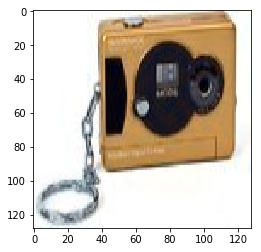

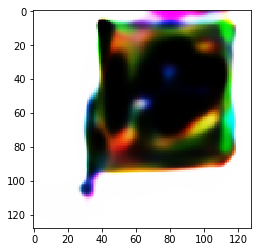

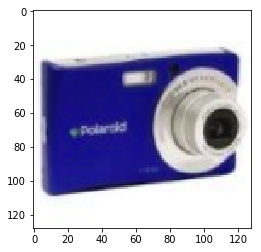

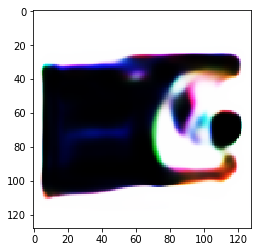

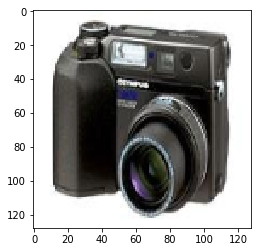

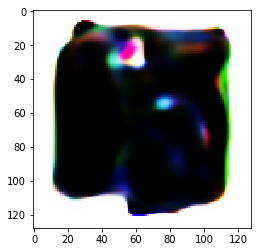

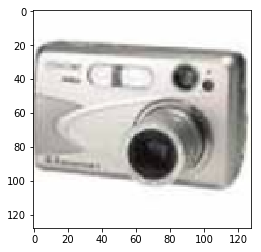

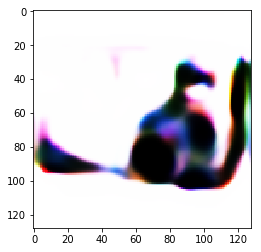

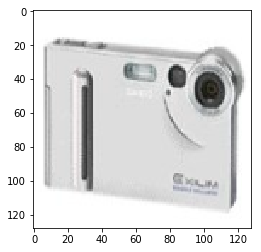

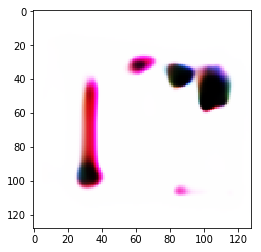

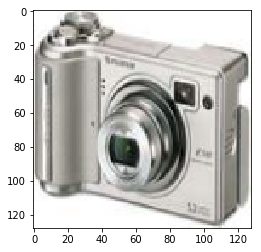

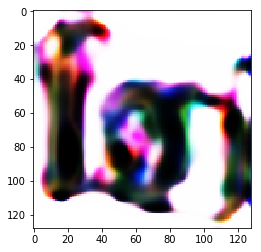

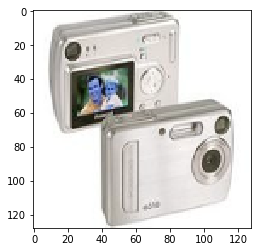

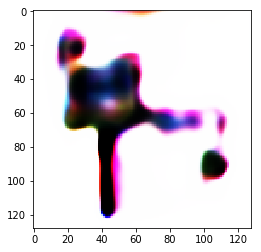

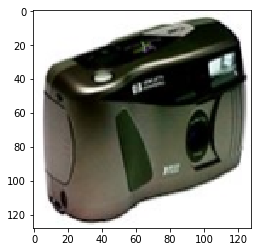

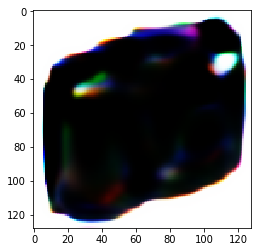

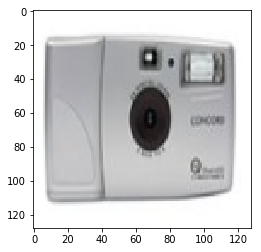

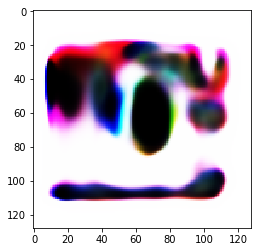

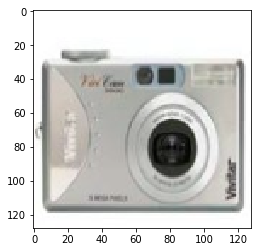

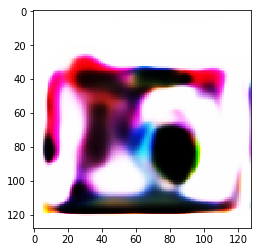

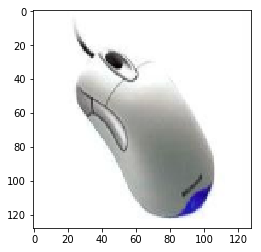

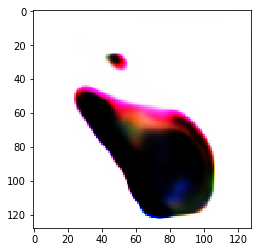

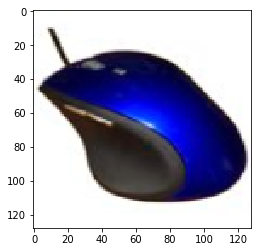

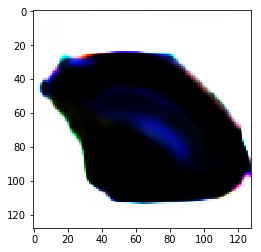

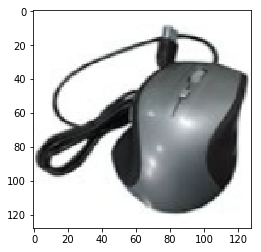

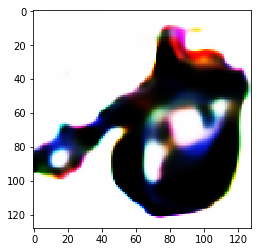

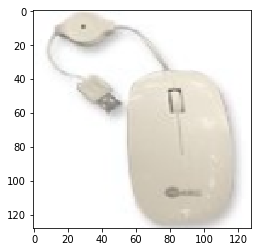

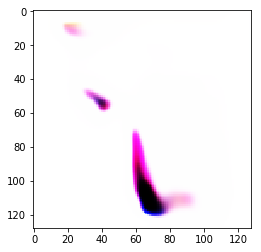

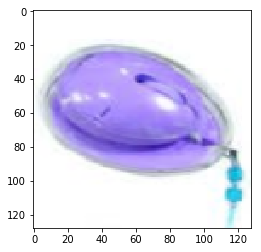

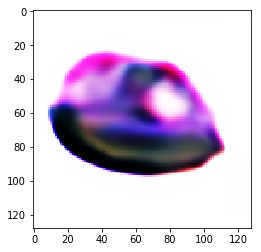

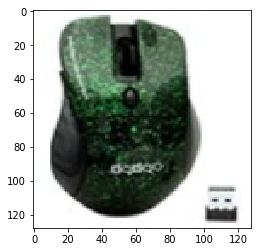

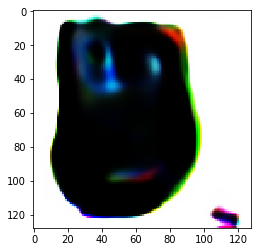

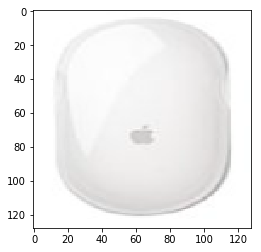

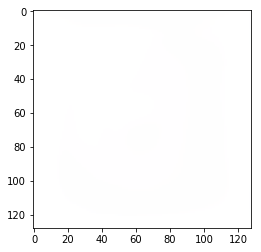

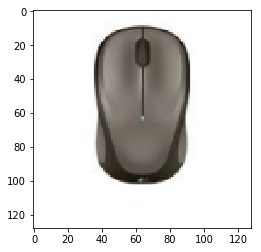

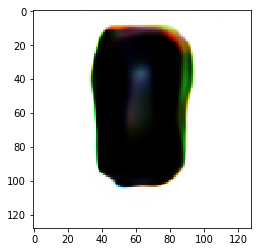

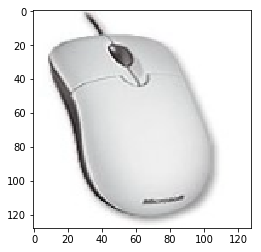

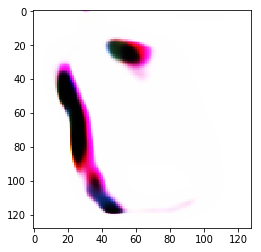

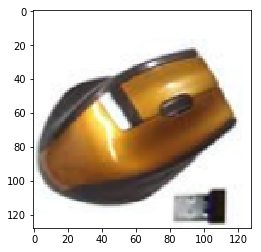

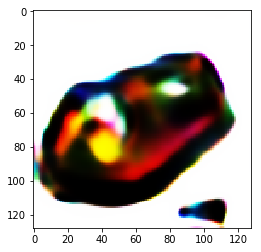

In [28]:
from PIL import Image
from IPython.display import Image, display

TINY = 1e-15
train_batch_size = 1

my_loader = load_data()

i = 0
max_images = 20
out = []
imgList = np.zeros((max_images,imagesize['c'],imagesize['x'],imagesize['y']))
reconimgList = np.zeros((max_images,imagesize['c'],imagesize['x'],imagesize['y']))
imgZValue = np.zeros((max_images,64,16,16))
filepath = "data/train_data"
hdf5_file = tables.open_file(filepath, "r")
# To access images array:
trainset_unlabeled = hdf5_file.root.images
batches = np.split(trainset_unlabeled, len(trainset_unlabeled)/train_batch_size)
for  X in batches:
    if i>=max_images:
        break
    out = X
    imgList[i] = out[0]
    t = Q(transformForNetwork(out))
    imgZValue[i] = t.cpu().data.numpy()
    reconimg =  P(t)
    reconimgList[i] = reconimg.cpu().data.numpy()
    showarray(out)
    showarray(1-(reconimgList[i]))
    i+=1

In [ ]:
showarray(imgList[0])

In [ ]:
diff_matrix = np.zeros((max_images,max_images))
for i in range(0,max_images):
    for j in range(0,max_images):
        #print(diff_matrix[i,j])
        diff_matrix[i,j]=math.sqrt(sum(np.power(imgZValue[i] - imgZValue[j],2)))
        #print(imgZValue[i] - imgZValue[j])
#print(diff_matrix)
plt.scatter(imgZValue[:,0],imgZValue[:,1])
plt.show()